# CamShift algorithm

   Explanations of the CamShift algorithm can be found at
   - [https://docs.opencv.org/4.x/d7/d00/tutorial_meanshift.html](https://docs.opencv.org/4.x/d7/d00/tutorial_meanshift.html)
   - [https://medium.com/@claudio.vindimian/understanding-and-implementing-the-camshift-object-tracking-algorithm-python-81587c24eda8](https://medium.com/@claudio.vindimian/understanding-and-implementing-the-camshift-object-tracking-algorithm-python-81587c24eda8)

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Read the video object

In [2]:
cap = cv2.VideoCapture('data/hrnecek.mp4')
cap

< cv2.VideoCapture 000001E7A280FD30>

In [3]:
cap.get(cv2.CAP_PROP_FPS)

30.0

In [4]:
cap.get(cv2.CAP_PROP_FRAME_WIDTH)

640.0

In [5]:
cap.get(cv2.CAP_PROP_POS_FRAMES)

0.0

In [6]:
ret, bgr = cap.read()  # reads the next frame
ret

True

In [7]:
bgr.shape, bgr.dtype

((480, 640, 3), dtype('uint8'))

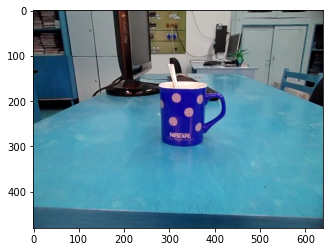

In [8]:
plt.imshow(bgr);

# CamShift step by step

## 1. Initialization

### 1.1. Position of the object

In [9]:
x1, y1 = 280, 160  # top-left
x2, y2 = 380, 295  # bottom-right

In [10]:
xc, yc = (x1 + x2) / 2, (y1 + y2) / 2  # center of the rectangle
xc, yc

(330.0, 227.5)

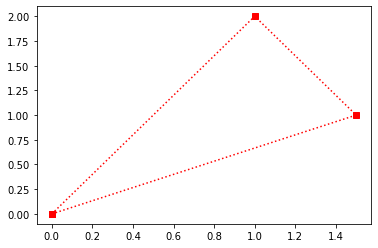

In [11]:
plt.plot([0., 1., 1.5, 0.], [0., 2., 1., 0.], linestyle=':', color='r', marker='s');

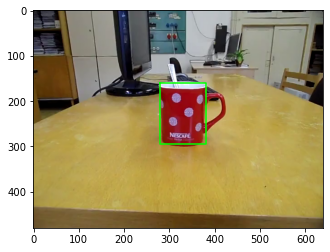

In [12]:
plt.imshow(bgr[..., ::-1])
plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], '-', color=(0, 1, 0));

### 1.2. Histogram of the hue component of the object

In [13]:
roi = bgr[y1:y2+1, x1:x2+1, ::-1]  # roi ... region of interest (rgb order)
roi.shape, roi.dtype

((136, 101, 3), dtype('uint8'))

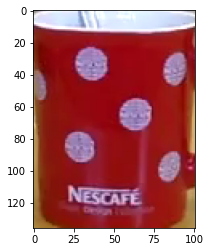

In [14]:
plt.imshow(roi);

In [15]:
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)

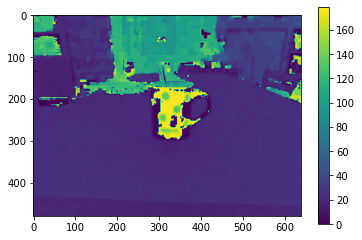

In [16]:
plt.imshow(hsv[..., 0])
plt.colorbar();

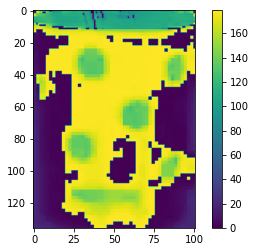

In [17]:
plt.imshow(hsv[y1:y2+1, x1:x2+1, 0])  # only show the object
plt.colorbar();

In [18]:
h0, b0 = np.histogram(hsv[y1:y2+1, x1:x2+1, 0], bins=np.arange(257))  # only computed from the roi
h0.shape

(256,)

In [19]:
np.sum(hsv[y1:y2+1, x1:x2+1, 0] == 178)  # how many pixels in roi have exactly value 178

1688

In [20]:
h0[178]  # # how many pixels in roi have exactly value 178

1688

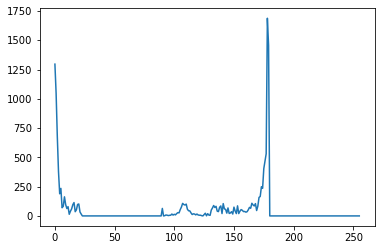

In [21]:
plt.plot(b0[:-1], h0);

## 2. Process next frame

In [22]:
ret, bgr = cap.read()  # read the next frame
ret

True

In [23]:
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)  # convert to HSV
hsv.shape, hsv.dtype

((480, 640, 3), dtype('uint8'))

### 2.1. Histogram back projection

#### For the entire image (better for visualisation)

In [24]:
bp = np.zeros(bgr.shape[:2])
bp.shape

(480, 640)

In [25]:
%%time

for i in range(bp.shape[0]):
    for j in range(bp.shape[1]):
        h_ij = hsv[i, j, 0]
        bp[i, j] = h0[h_ij]

CPU times: total: 93.8 ms
Wall time: 227 ms


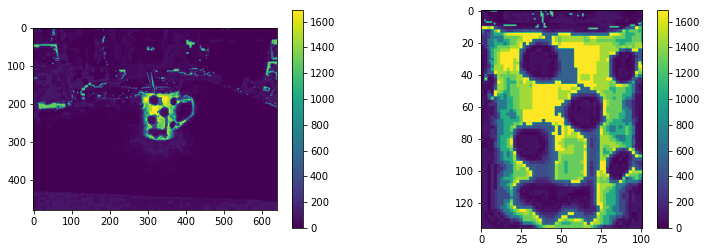

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(bp)
plt.colorbar();
plt.subplot(1, 2, 2)
plt.imshow(bp[y1:y2+1, x1:x2+1])
plt.colorbar();

#### Only for the region of interest (will be faster)

In [27]:
roi_bp = np.zeros(roi.shape[:2])
roi_bp.shape

(136, 101)

In [28]:
%%time

for i in range(roi_bp.shape[0]):
    for j in range(roi_bp.shape[1]):
        h_ij = hsv[y1 + i, x1 + j, 0]
        roi_bp[i, j] = h0[h_ij]

CPU times: total: 0 ns
Wall time: 13.5 ms


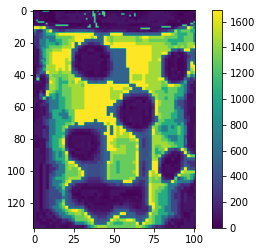

In [29]:
plt.imshow(roi_bp)
plt.colorbar();

#### Using Numpy indexing (good for visualisation and super fast)

In [30]:
%%time

bp_ = h0[hsv[..., 0]]

CPU times: total: 0 ns
Wall time: 2 ms


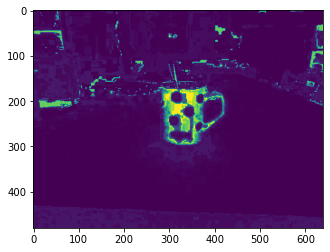

In [31]:
plt.imshow(bp_);

In [32]:
np.all(bp == bp_)

True

### 2.2. Compute the center of gravity of the ROI backprojection

In [33]:
%%time

n_, xc_, yc_ = 0., 0., 0.
for i in range(y1, y2 + 1):
    for j in range(x1, x2 + 1):
        xc_ += j * bp[i, j]
        yc_ += i * bp[i, j]
        n_ += bp[i, j]
xc_ /= n_
yc_ /= n_
xc_, yc_

CPU times: total: 15.6 ms
Wall time: 22 ms


(331.62266778757066, 224.48564502788935)

In [34]:
# bounding box translation vector (new center minus old center)
dx = xc_ - xc
dy = yc_ - yc
dx, dy 

(1.6226677875706628, -3.0143549721106524)

In [35]:
# new coordinates of the bounding box and round the coordinates to integers
x1_ = int(0.5 + x1 + dx)
y1_ = int(0.5 + y1 + dy)
x2_ = int(0.5 + x2 + dx)
y2_ = int(0.5 + y2 + dy)
x1_, y1_, x2_, y2_

(282, 157, 382, 292)

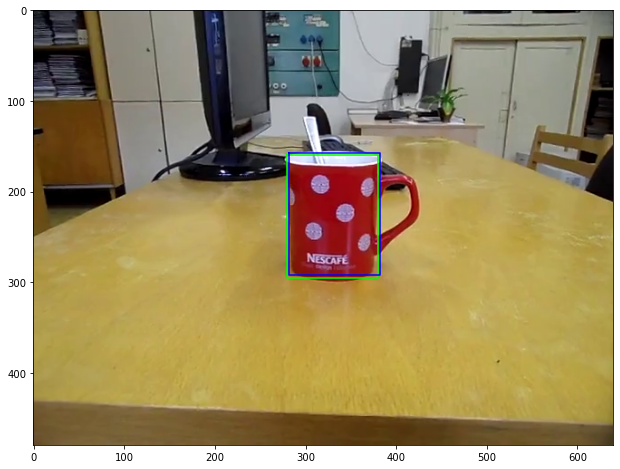

In [36]:
plt.figure(figsize=(12, 8))
plt.imshow(bgr[..., ::-1])  # imshow the new image
plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], '-', color=(0, 1, 0))  # plot the old bounding box
plt.plot([x1_, x2_, x2_, x1_, x1_], [y1_, y1_, y2_, y2_, y1_], '-', color=(0, 0, 1))  # plot the new bounding box
plt.show();

# Homework: Put it all together in a loop

## Initialization

In [37]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [38]:
cap = cv2.VideoCapture('data/hrnecek.mp4')
ret, bgr = cap.read()

In [39]:

# initial bounding box
x1, x2 = 280, 380
y1, y2 = 160, 295
xc, yc = (x1 + x2)/2 , (y1 +y2)/2

In [40]:
# convert to HSV
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)

In [41]:
# calculate the histogram from the hue component
h0, b0 = np.histogram(hsv[y1:y2+1, x1:x2+1, 0], bins=np.arange(257))
h0.shape

(256,)

## Main loop

In [42]:
while True:
    ret, bgr = cap.read()
    if not ret:
        break
    
#     # convert to HSV
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV) 
    
#     # calculate the backprojection
    bp = h0[hsv[..., 0]]
#     # calculate the new center of gravity
    n_, xc_, yc_ = 0., 0., 0.
    for i in range(y1, y2 + 1):
        for j in range(x1, x2 + 1):
            xc_ += j * bp[i, j]
            yc_ += i * bp[i, j]
            n_ += bp[i, j]
    xc_ /= n_
    yc_ /= n_

#     # translation vector of the bounding
    dx = xc_ - xc
    dy = yc_ - yc
    
#     # new coordinates of the bounding box
    x1_ = int(0.5 + x1 + dx)
    y1_ = int(0.5 + y1 + dy)
    x2_ = int(0.5 + x2 + dx)
    y2_ = int(0.5 + y2 + dy)
    
#     # make sure that x1_, x2_ etc. are inside te image
    if x1_ > 640:
        x1_ = 640
    if x2_ > 640:
        x2_ = 640
    if y1_ > 480:
        y1_ = 480
    if y2_ > 480:
        y2_ = 480
    if x1_ < 0:
        x1_ = 0
    if x2_ < 0:
        x2_ = 0
    if y1_ < 0:
        y1_ = 0
    if y2_ < 0:
        y2_ = 0

    # overwrite the old coordinates                
    x1, y1, x2, y2, xc, yc = x1_, y1_, x2_, y2_, xc_, yc_
    
    # imshow and plot the bounding (using opencv as it's faster)
    cv2.line(bgr, (x1, y1), (x2, y1), (0, 255, 0))
    cv2.line(bgr, (x2, y1), (x2, y2), (0, 255, 0))
    cv2.line(bgr, (x2, y2), (x1, y2), (0, 255, 0))
    cv2.line(bgr, (x1, y2), (x1, y1), (0, 255, 0))
    cv2.imshow('input', bgr)
    key = cv2.waitKey(0)
    if key == 27:
        break  # escape key means stop

cv2.destroyAllWindows()